In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

train_path = '/content/drive/MyDrive/NLP_exam_emotions_dataset/train.txt'
val_path = '/content/drive/MyDrive/NLP_exam_emotions_dataset/validation.txt'

In [ ]:
train_df = pd.read_csv(train_path, sep=';', names=['text', 'label'])
val_df = pd.read_csv(val_path, sep=';', names=['text', 'label'])

In [ ]:
# Remove overlaps (optional)
overlap = set(train_df['text']).intersection(set(val_df['text']))
train_df = train_df[~train_df['text'].isin(overlap)].reset_index(drop=True)

In [ ]:
# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['label_enc'] = le.fit_transform(train_df['label'])
val_df['label_enc'] = le.transform(val_df['label'])

In [ ]:
# Convert to HuggingFace Datasets
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df[['text', 'label_enc']])
val_dataset = Dataset.from_pandas(val_df[['text', 'label_enc']])
train_dataset = train_dataset.rename_column('label_enc', 'label')
val_dataset = val_dataset.rename_column('label_enc', 'label')

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True, max_length=64)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/15995 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoConfig, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback

num_labels = len(le.classes_)

# Increased dropout in config
config = AutoConfig.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    attention_probs_dropout_prob=0.3,  # Increased dropout
    hidden_dropout_prob=0.3            # Increased dropout
)
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    config=config
)

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.1,  # Increased weight decay
    load_best_model_at_end=True,
    metric_for_best_model='eval_accuracy',
    report_to='none'
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

In [ ]:
import os
os.environ['WANDB_DISABLED'] = 'true'

In [ ]:
!pip install numpy==1.26.4


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Early stopping
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.248100,0.212946,0.928500,0.929477,0.933908,0.928500
2,0.155500,0.153745,0.932500,0.932807,0.933661,0.932500
3,0.104500,0.162568,0.938000,0.937999,0.938632,0.938000
4,0.070200,0.162401,0.939000,0.938741,0.938916,0.939000


TrainOutput(global_step=4000, training_loss=0.20605195426940917, metrics={'train_runtime': 456.5071, 'train_samples_per_second': 140.151, 'train_steps_per_second': 8.762, 'total_flos': 1059483592903680.0, 'train_loss': 0.20605195426940917, 'epoch': 4.0})

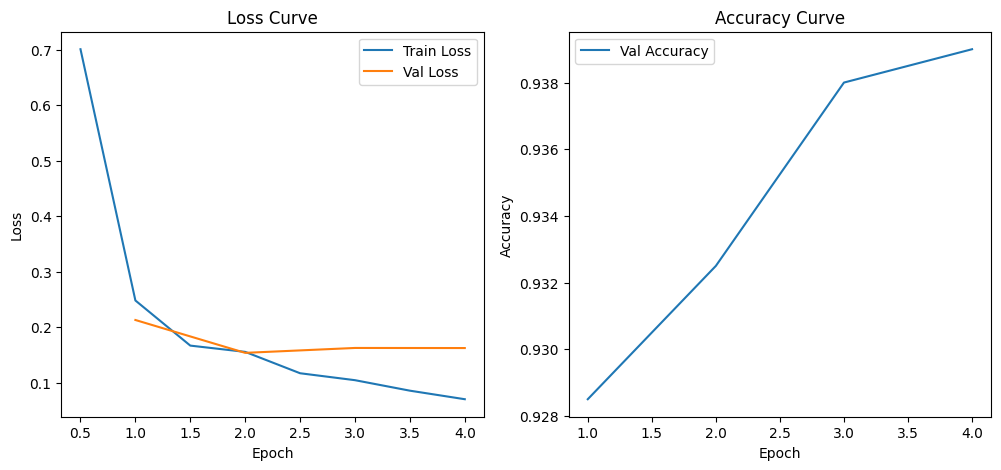

              precision    recall  f1-score   support

       anger       0.95      0.93      0.94       275
        fear       0.87      0.92      0.89       212
         joy       0.95      0.96      0.96       704
        love       0.90      0.84      0.87       178
     sadness       0.96      0.97      0.96       550
    surprise       0.88      0.84      0.86        81

    accuracy                           0.94      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.94      0.94      0.94      2000



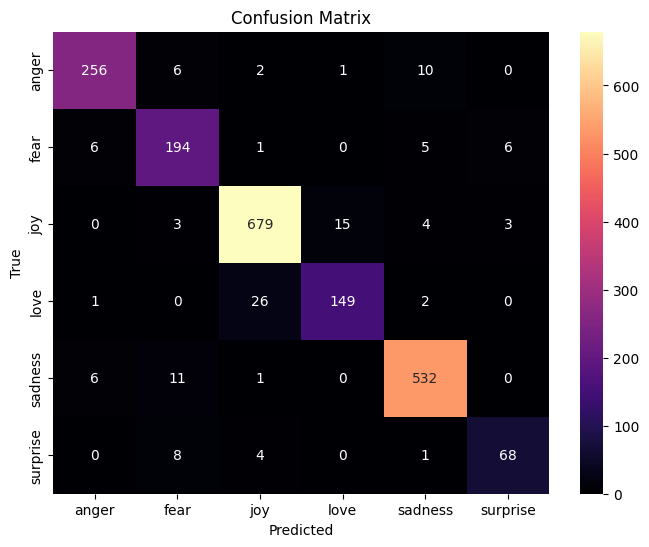

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Extract logs
logs = trainer.state.log_history
train_loss = [x['loss'] for x in logs if 'loss' in x and 'epoch' in x]
eval_loss = [x['eval_loss'] for x in logs if 'eval_loss' in x]
eval_acc = [x['eval_accuracy'] for x in logs if 'eval_accuracy' in x]
epochs = [x['epoch'] for x in logs if 'loss' in x and 'epoch' in x]
eval_epochs = [x['epoch'] for x in logs if 'eval_loss' in x]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(eval_epochs, eval_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(eval_epochs, eval_acc, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

# Get predictions
preds_output = trainer.predict(val_dataset)
y_true = preds_output.label_ids
y_pred = np.argmax(preds_output.predictions, axis=1)

# Classification report
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='magma')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Inference:

In [ ]:
import torch

In [ ]:
def predict_emotion(texts):
    tokens = tokenizer(texts, padding='max_length', truncation=True, max_length=64, return_tensors='pt')

    device = model.device
    tokens = {k: v.to(device) for k, v in tokens.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**tokens)
        preds = torch.argmax(outputs.logits, dim=1)

    return le.inverse_transform(preds.cpu().numpy())

sample_texts = [
    "I'm feeling so sad and empty today.",
    "I can't stop smiling, what a great day!",
    "I'm scared of what might happen next."
]
predicted_emotions = predict_emotion(sample_texts)
for text, emotion in zip(sample_texts, predicted_emotions):
    print(f"Text: {text}\nPredicted Emotion: {emotion}\n")

Text: I'm feeling so sad and empty today.
Predicted Emotion: sadness

Text: I can't stop smiling, what a great day!
Predicted Emotion: joy

Text: I'm scared of what might happen next.
Predicted Emotion: fear

